In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

from qiskit_aer import AerSimulator
from qiskit. circuit.library import RealAmplitudes, EfficientSU2
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms import VQC
from qiskit. primitives import Sampler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, classification_report

algorithm_globals.random_seed = 42
np.random.seed(42)

/tmp/ipykernel_16213/487187359.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load preprocessed data
X_train = pd.read_csv('../data/processed/X_train_selected.csv')
X_test = pd.read_csv('../data/processed/X_test_selected.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values. ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

# Clean data (same as classical models)
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Convert to numpy
X_train_np = X_train.values
X_test_np = X_test.values

print(f"Training set:   {X_train_np. shape}")
print(f"Test set:  {X_test_np.shape}")
print(f"\nClass distribution:")
print(f"  Training - Fraud: {sum(y_train==1)}, Non-Fraud: {sum(y_train==0)}")
print(f"  Test - Fraud: {sum(y_test==1)}, Non-Fraud: {sum(y_test==0)}")

Training set:   (80000, 4)
Test set:  (20000, 4)

Class distribution:
  Training - Fraud: 6992, Non-Fraud: 73008
  Test - Fraud: 1748, Non-Fraud: 18252


In [3]:
# Balance the dataset for quantum training
# Quantum models struggle with severe class imbalance

# Get fraud and non-fraud samples separately
fraud_idx = np.where(y_train == 1)[0]
non_fraud_idx = np.where(y_train == 0)[0]

# Take equal samples from each class
n_fraud_train = min(200, len(fraud_idx))  # 200 fraud samples
n_non_fraud_train = 200  # 200 non-fraud samples

# Random selection
np.random.seed(42)
fraud_sample = np.random. choice(fraud_idx, n_fraud_train, replace=False)
non_fraud_sample = np.random.choice(non_fraud_idx, n_non_fraud_train, replace=False)

# Combine and shuffle
train_idx = np.concatenate([fraud_sample, non_fraud_sample])
np.random.shuffle(train_idx)

X_train_sub = X_train_np[train_idx]
y_train_sub = y_train[train_idx]

# Same for test
fraud_idx_test = np.where(y_test == 1)[0]
non_fraud_idx_test = np.where(y_test == 0)[0]

n_fraud_test = min(75, len(fraud_idx_test))
n_non_fraud_test = 75

fraud_sample_test = np. random.choice(fraud_idx_test, n_fraud_test, replace=False)
non_fraud_sample_test = np.random.choice(non_fraud_idx_test, n_non_fraud_test, replace=False)

test_idx = np.concatenate([fraud_sample_test, non_fraud_sample_test])
np.random.shuffle(test_idx)

X_test_sub = X_test_np[test_idx]
y_test_sub = y_test[test_idx]

print(f"Balanced dataset for VQC:")
print(f"\nTraining set:  {len(X_train_sub)} samples")
print(f"  Fraud: {sum(y_train_sub==1)}")
print(f"  Non-Fraud: {sum(y_train_sub==0)}")
print(f"\nTest set: {len(X_test_sub)} samples")
print(f"  Fraud:  {sum(y_test_sub==1)}")
print(f"  Non-Fraud: {sum(y_test_sub==0)}")
print("\n✓ Balanced dataset created!")

Balanced dataset for VQC:

Training set:  400 samples
  Fraud: 200
  Non-Fraud: 200

Test set: 150 samples
  Fraud:  75
  Non-Fraud: 75

✓ Balanced dataset created!


In [4]:
# Load the ZZ feature map we created
with open('../models/feature_maps.pkl', 'rb') as f:
    feature_maps = pickle.load(f)

feature_map = feature_maps['zz_feature_map']
n_qubits = feature_maps['n_qubits']

print("="*60)
print("FEATURE MAP LOADED")
print("="*60)
print(f"Feature Map:  ZZ Feature Map")
print(f"Qubits: {n_qubits}")
print(f"Parameters: {feature_map.num_parameters}")
print(f"Depth: {feature_map. depth()}")

FEATURE MAP LOADED
Feature Map:  ZZ Feature Map
Qubits: 4
Parameters: 4
Depth: 1


In [5]:
print("\n" + "="*60)
print("CREATING VARIATIONAL ANSATZ")
print("="*60)

# EfficientSU2 - better for classification than RealAmplitudes
ansatz = EfficientSU2(
    num_qubits=n_qubits, 
    reps=2,  # 2 reps - good balance
    entanglement='circular'  # circular entanglement
)

print(f"\n✓ Ansatz Created: EfficientSU2")
print(f"  Qubits: {ansatz.num_qubits}")
print(f"  Trainable Parameters: {ansatz.num_parameters}")
print(f"  Depth: {ansatz.depth()}")
print(f"  Entanglement: circular")


CREATING VARIATIONAL ANSATZ

✓ Ansatz Created: EfficientSU2
  Qubits: 4
  Trainable Parameters: 24
  Depth: 1
  Entanglement: circular


✓ Circuit saved successfully!


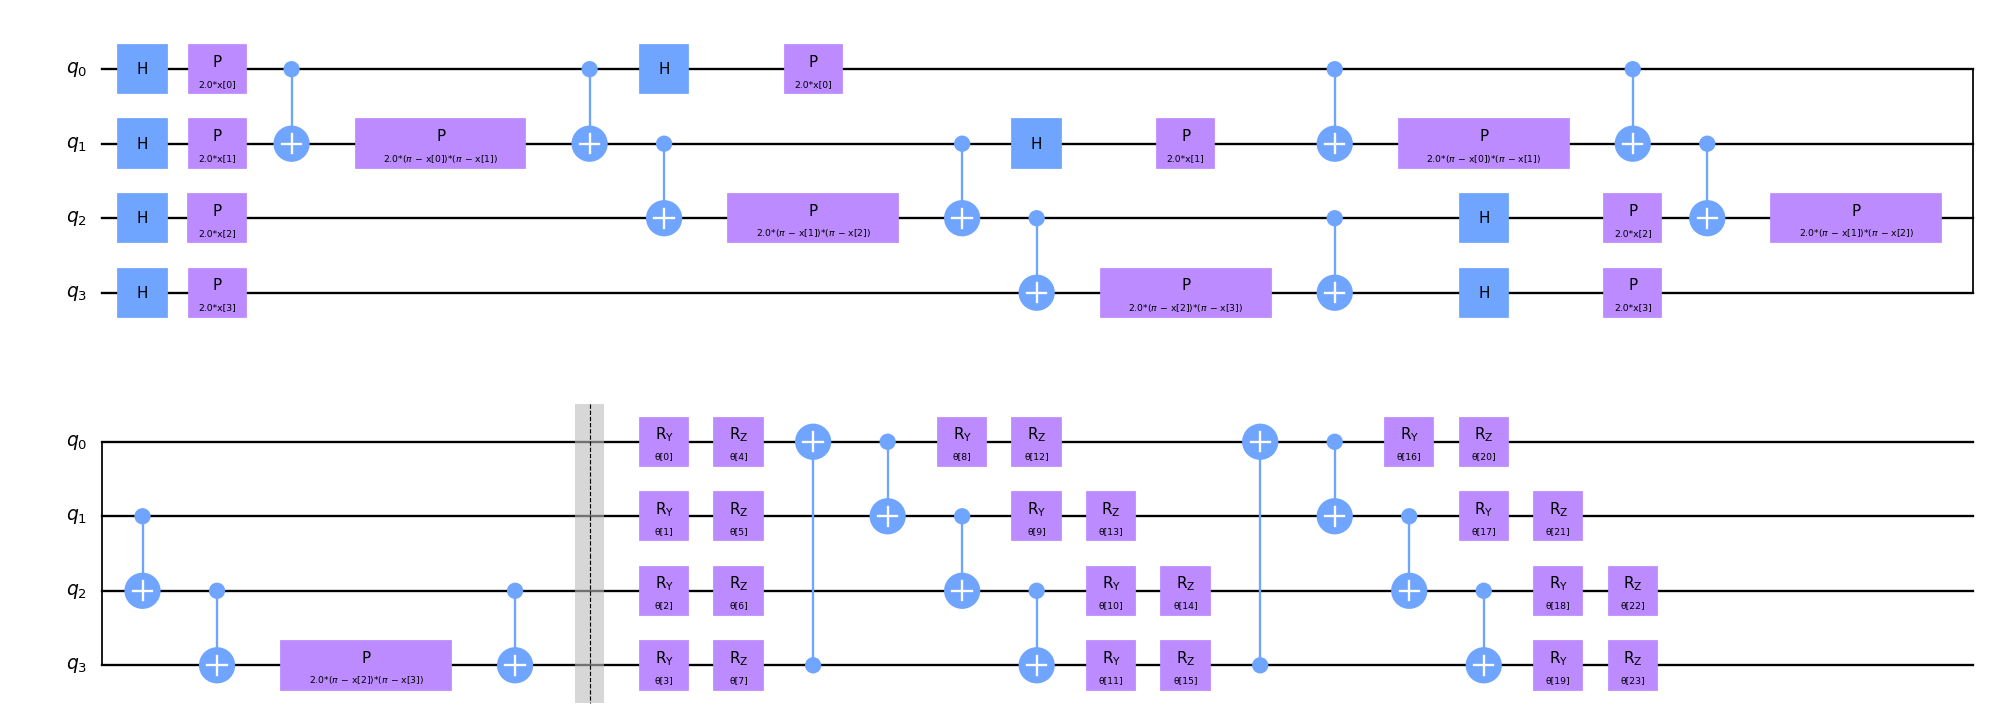

In [6]:
# Quick circuit visualization 
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
import matplotlib.pyplot as plt
import pickle

# Load feature map
with open('../models/feature_maps.pkl', 'rb') as f:
    feature_maps = pickle.load(f)

feature_map = feature_maps['zz_feature_map']
ansatz = EfficientSU2(num_qubits=4, reps=2, entanglement='circular')

# Build complete circuit
complete_circuit = QuantumCircuit(4)
complete_circuit.compose(feature_map, inplace=True)
complete_circuit.barrier()
complete_circuit.compose(ansatz, inplace=True)

# Draw it
plt.figure(figsize=(20, 8))
complete_circuit.decompose().draw('mpl', style='clifford', fold=25, ax=plt.gca())
plt.tight_layout()
plt.savefig('../figures/vqc_complete_circuit.png', dpi=300, bbox_inches='tight')
print("✓ Circuit saved successfully!")
plt.show()

In [7]:
print("="*60)
print("SETTING UP VQC COMPONENTS")
print("="*60)

# Use Sampler
sampler = Sampler()
print("✓ Sampler initialized")

# SPSA optimizer - better for quantum classification
optimizer = SPSA(maxiter=100)  # 100 iterations
print(f"✓ Optimizer:  SPSA (max iterations: 100)")

print("\nReady to train VQC!")

SETTING UP VQC COMPONENTS
✓ Sampler initialized
✓ Optimizer:  SPSA (max iterations: 100)

Ready to train VQC!


In [8]:
print("\n" + "="*60)
print("CREATING VQC MODEL")
print("="*60)

# Create VQC classifier
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer
)

print("✓ VQC Classifier created successfully!")
print(f"\nModel architecture:")
print(f"  Input: {n_qubits} features → {n_qubits} qubits")
print(f"  Feature encoding: ZZ Feature Map")
print(f"  Variational circuit: RealAmplitudes")
print(f"  Trainable parameters: {ansatz.num_parameters}")
print(f"  Optimizer: COBYLA")


CREATING VQC MODEL
✓ VQC Classifier created successfully!

Model architecture:
  Input: 4 features → 4 qubits
  Feature encoding: ZZ Feature Map
  Variational circuit: RealAmplitudes
  Trainable parameters: 24
  Optimizer: COBYLA


In [9]:
print("\n" + "="*60)
print("TRAINING VQC - THIS WILL TAKE 15-25 MINUTES")
print("="*60)
print("Please be patient...  Quantum simulation is slow!")
print("You can monitor progress below:\n")

# Train the VQC
vqc.fit(X_train_sub, y_train_sub)

print("\n" + "="*60)
print("✓ VQC TRAINING COMPLETE!")
print("="*60)


TRAINING VQC - THIS WILL TAKE 15-25 MINUTES
Please be patient...  Quantum simulation is slow!
You can monitor progress below:


✓ VQC TRAINING COMPLETE!


In [ ]:
print("\n" + "="*60)
print("EVALUATING VQC")
print("="*60)

# Predictions on test set
print("Making predictions on test set...")
y_pred_vqc = vqc.predict(X_test_sub)

# Calculate metrics
acc_vqc = accuracy_score(y_test_sub, y_pred_vqc)
precision_vqc = precision_score(y_test_sub, y_pred_vqc, zero_division=0)
recall_vqc = recall_score(y_test_sub, y_pred_vqc, zero_division=0)
f1_vqc = f1_score(y_test_sub, y_pred_vqc, zero_division=0)

print("\n" + "="*60)
print("VQC RESULTS")
print("="*60)
print(f"Accuracy:    {acc_vqc:.4f}")
print(f"Precision:  {precision_vqc:.4f}")
print(f"Recall:     {recall_vqc:.4f}")
print(f"F1-Score:   {f1_vqc:.4f}")
print("="*60)

print("\nClassification Report:")
print(classification_report(y_test_sub, y_pred_vqc, 
                           target_names=['Non-fraud', 'fraud']))

In [ ]:
# Load classical results
classical_results = pd.read_csv('../results/classical_results.csv')

# Add VQC results
vqc_results = pd.DataFrame({
    'Model': ['VQC (Quantum)'],
    'Accuracy': [acc_vqc],
    'Precision': [precision_vqc],
    'Recall':  [recall_vqc],
    'F1-Score': [f1_vqc],
    'AUC-ROC': [np.nan]  # VQC doesn't directly give probabilities easily
})

# Combine results
all_results = pd.concat([classical_results, vqc_results], ignore_index=True)

print("\n" + "="*70)
print("QUANTUM vs CLASSICAL COMPARISON")
print("="*70)
print(all_results. to_string(index=False))
print("="*70)

In [ ]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = all_results['Model']
accuracy = all_results['Accuracy']

colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'red']
axes[0].bar(models, accuracy, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Accuracy:  Quantum vs Classical', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(accuracy):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# F1-Score comparison
f1_scores = all_results['F1-Score']
axes[1]. bar(models, f1_scores, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_title('F1-Score:  Quantum vs Classical', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/quantum_vs_classical.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved: figures/quantum_vs_classical.png")

In [ ]:
# VQC models cannot be saved with joblib - skip model saving
print("⚠ VQC model cannot be serialized - skipping model save")
print("  (This is a known Qiskit limitation)")
print("  You can retrain the model by re-running this notebook")

# Save VQC results only
vqc_results. to_csv('../results/vqc_results.csv', index=False)
print("\n✓ VQC results saved:  results/vqc_results.csv")

# Save combined results
all_results.to_csv('../results/all_results.csv', index=False)
print("✓ Combined results saved: results/all_results.csv")

# Save VQC predictions for analysis
vqc_predictions = pd.DataFrame({
    'y_true': y_test_sub,
    'y_pred':  y_pred_vqc
})
vqc_predictions.to_csv('../results/vqc_predictions.csv', index=False)
print("✓ VQC predictions saved: results/vqc_predictions.csv")

# Save training configuration for reproducibility
config = {
    'feature_map': 'ZZ Feature Map',
    'ansatz': 'EfficientSU2',
    'optimizer': 'SPSA',
    'max_iterations': 100,
    'n_qubits': n_qubits,
    'training_samples': len(X_train_sub),
    'test_samples': len(X_test_sub),
    'accuracy':  acc_vqc,
    'precision': precision_vqc,
    'recall': recall_vqc,
    'f1_score':  f1_vqc
}

import json
with open('../results/vqc_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✓ VQC configuration saved: results/vqc_config.json")
print("\n" + "="*60)
print("✓ All results saved successfully!")
print("="*60)

In [ ]:
print("\n" + "="*70)
print("VQC TRAINING COMPLETE!")
print("="*70)
print(f"\nQuantum Model Performance:")
print(f"  Accuracy:   {acc_vqc:.4f}")
print(f"  F1-Score:  {f1_vqc:.4f}")
print(f"\nBest Classical Model:")
best_classical_idx = classical_results['Accuracy'].idxmax()
best_classical = classical_results.loc[best_classical_idx]
print(f"  Model: {best_classical['Model']}")
print(f"  Accuracy: {best_classical['Accuracy']:.4f}")
print(f"\nQuantum vs Classical:")
diff = acc_vqc - best_classical['Accuracy']
if diff > 0:
    print(f"  ✓ Quantum is BETTER by {diff:.4f}")
elif diff > -0.05:
    print(f"  ≈ Quantum is COMPETITIVE (within {abs(diff):.4f})")
else:
    print(f"  Classical is better by {abs(diff):.4f}")
print(f"\nQuantum advantage:")
print(f"  - Uses only {ansatz.num_parameters} trainable parameters")
print(f"  - Potentially better scaling for complex patterns")
print("="*70)